In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
open('names.txt', 'r').read()[:500]

'emma\nolivia\nava\nisabella\nsophia\ncharlotte\nmia\namelia\nharper\nevelyn\nabigail\nemily\nelizabeth\nmila\nella\navery\nsofia\ncamila\naria\nscarlett\nvictoria\nmadison\nluna\ngrace\nchloe\npenelope\nlayla\nriley\nzoey\nnora\nlily\neleanor\nhannah\nlillian\naddison\naubrey\nellie\nstella\nnatalie\nzoe\nleah\nhazel\nviolet\naurora\nsavannah\naudrey\nbrooklyn\nbella\nclaire\nskylar\nlucy\npaisley\neverly\nanna\ncaroline\nnova\ngenesis\nemilia\nkennedy\nsamantha\nmaya\nwillow\nkinsley\nnaomi\naaliyah\nelena\nsarah\nariana\nallison\ngabriella\nalice\nmadelyn\ncora\nru'

In [4]:
len(words)

32033

In [5]:
print(set(''.join(words)))

{'v', 'd', 'x', 'h', 'y', 'r', 'k', 'e', 'a', 'w', 'p', 'j', 'z', 'q', 'o', 'l', 'n', 'u', 'g', 'i', 'c', 'f', 'b', 's', 't', 'm'}


In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
[0] * 3

[0, 0, 0]

In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
n_embd = 10 # no of dimensions each character will have after embedding
n_hidden = 200 # no of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * ((5/3) / (n_embd*block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.001
b2 = torch.randn(vocab_size, generator=g) * 0

# the following prameters will allow backprop to control batch norm.
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print("Total params: ", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

Total params:  12297


In [10]:
(torch.randn(1000) * 0.2).std()

tensor(0.2041)

In [11]:
# kaiming init
((5/3) / (n_embd*block_size)**0.5)

0.3042903097250923

In [12]:
max_steps = 200000
batch_size = 32
losses = []
steps = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb] # embedded the training data
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1 # hidden layer + activation func.
    # batch norm.
    bnmeani = h_pre_act.mean(dim=0, keepdim=True)
    bnstdi = h_pre_act.std(dim=0, keepdim=True)
    h_pre_act = bngain * ((h_pre_act - bnmeani) / bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(h_pre_act)
    
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # backprop
    for p in parameters:
        p.grad = None
    loss.backward()

    # updation
    lr = 0.1 if i<100000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    losses.append(loss.item())
    steps.append(i)
    if i%10000 == 0:
        print(f"{i}/{max_steps}   {loss.item():.4f}")

/home/nuclea/miniconda3/envs/common/lib/python3.10/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115564/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0/200000   3.2974
10000/200000   2.2039
20000/200000   2.3172
30000/200000   2.4374
40000/200000   2.0127
50000/200000   2.2896
60000/200000   2.4485
70000/200000   2.0918
80000/200000   2.2562
90000/200000   2.1923
100000/200000   1.9478
110000/200000   2.3251
120000/200000   2.0012
130000/200000   2.4648
140000/200000   2.4478
150000/200000   2.2452
160000/200000   1.9925
170000/200000   1.8927
180000/200000   2.0509
190000/200000   1.8600


In [13]:
# batch norm.
((h_pre_act - h_pre_act.mean(dim=0, keepdim=True)) / h_pre_act.std(dim=0, keepdim=True))

tensor([[ 1.0822e+00,  1.7200e+00,  2.1314e-01,  ..., -1.5928e+00,
          1.1259e+00,  1.0464e+00],
        [ 1.1112e+00,  5.5031e-01, -9.5534e-01,  ..., -8.5557e-01,
          2.3415e+00,  8.9456e-01],
        [-3.0343e-01,  5.5340e-01, -1.6153e+00,  ...,  1.0895e+00,
         -1.1870e+00, -9.6174e-01],
        ...,
        [-6.4712e-01, -6.6592e-01, -3.9149e-01,  ...,  3.4449e-01,
         -2.4883e-03, -4.8940e-01],
        [ 6.6776e-01,  2.9956e-01,  1.0306e+00,  ..., -3.6684e-01,
         -5.9049e-01,  4.3854e-01],
        [-5.0509e-01, -1.4733e-01, -3.1791e+00,  ...,  2.0311e-01,
          4.8959e-01,  5.5848e-01]], grad_fn=<DivBackward0>)

In [14]:
embcat = emb.view(emb.shape[0], -1) # concatination 32,3,10 -> 32,30
embcat.shape, Xb.shape, emb.shape, W1.shape

(torch.Size([32, 30]),
 torch.Size([32, 3]),
 torch.Size([32, 3, 10]),
 torch.Size([30, 200]))

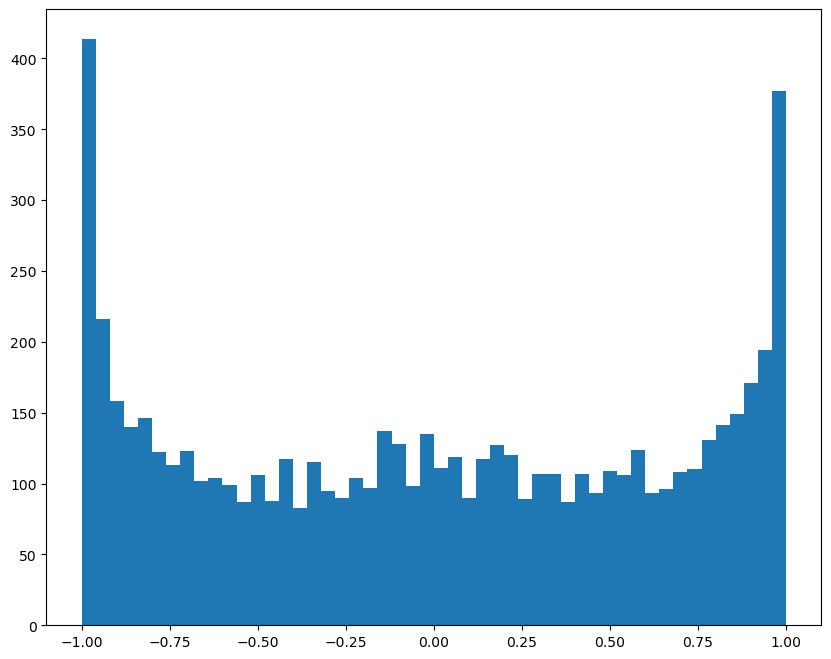

In [15]:
# checking values of h
plt.figure(figsize=(10,8))
plt.hist(h.view(-1).tolist(), bins=50)
plt.show()

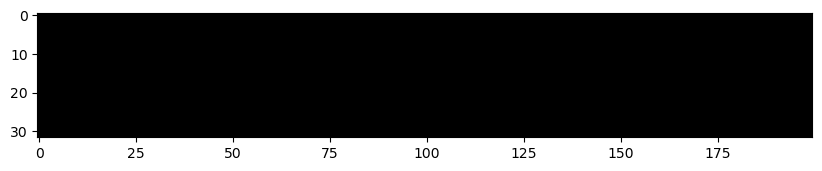

In [16]:
plt.figure(figsize=(10,8))
plt.imshow(h.abs() == 1.0, cmap='gray')
plt.show()

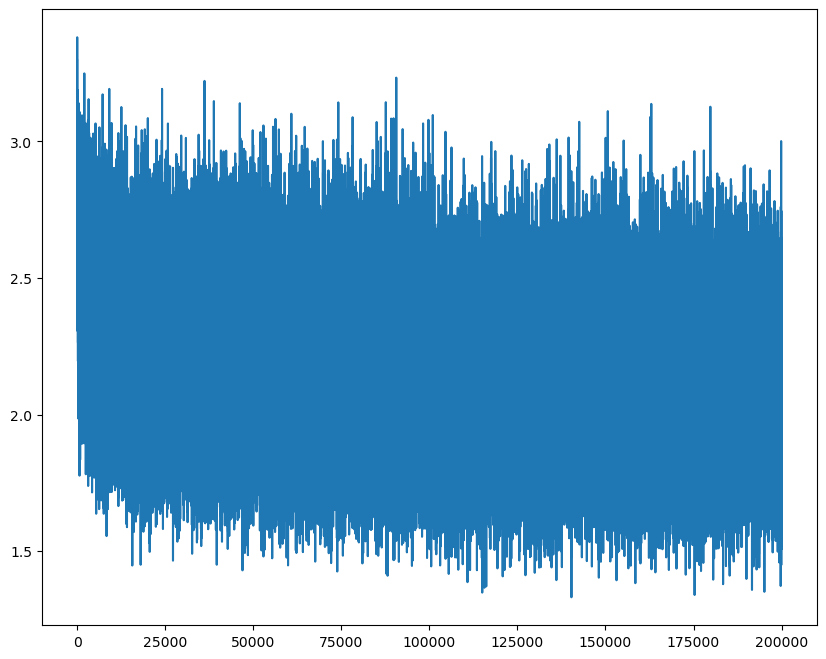

In [17]:
plt.figure(figsize=(10,8))
plt.plot(steps, losses)
plt.show()

In [18]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure mean / std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [19]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'test' : (Xte, Yte),
        'validation' : (Xdev, Ydev)
    }[split]
    emb = C[x]
    embcat = emb.view(x.shape[0], -1) # concatination
    h_pre_act = embcat @ W1 + b1
    # h_pre_act = bngain * ((h_pre_act - h_pre_act.mean(dim=0, keepdim=True)) / h_pre_act.std(dim=0, keepdim=True)) + bnbias
    h_pre_act = bngain * ((h_pre_act - bnmean) / bnstd) + bnbias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, " : ", loss.item())

split_loss('test')
split_loss('validation')

test  :  2.1081461906433105
validation  :  2.10760498046875


In [20]:
# creating sample names
g = torch.Generator()
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2 # shape: [1, 27]
        # print("logits: ", logits.shape)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)        
        # if ix = '.' then we break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

debianayffigh.
quslainyah.
die.
bdierrixell.
sulipslanirthell.
bububacklyssn.
grachvishntbely.
blvianayrdssaambryff.
budaliffrinishbir.
shanargunnishbrnnyushcgblllogrickllissannixtobbigh.
lecsloltdya.
dasgbyc.
blgaerekslayrds.
daldyn.
bobbigalykagghmylissa.
fumbdyo.
fgrrykshntdy.
viyamariyvangulds.
dyybiandh.
brianabdus.


In [64]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, X):
        self.out = X @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with back prop)
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def __call__(self, X):
        # calculate forward pass
        if self.training:
            xmean = X.mean(0, keepdim=True) 
            xvar = X.var(0, keepdim=True) 
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (X - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta # scale and shift
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, X):
        self.out = torch.tanh(X)
        return self.out
    def parameters(self):
        return []


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [65]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
      break

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


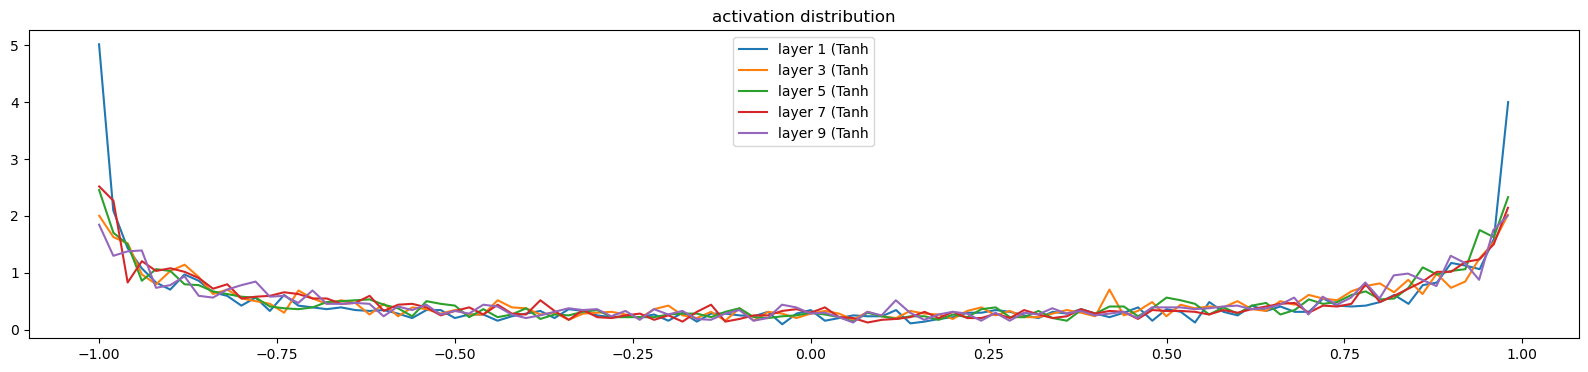

In [66]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

layer 1 (      Tanh): mean +0.000024, std 3.353993e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


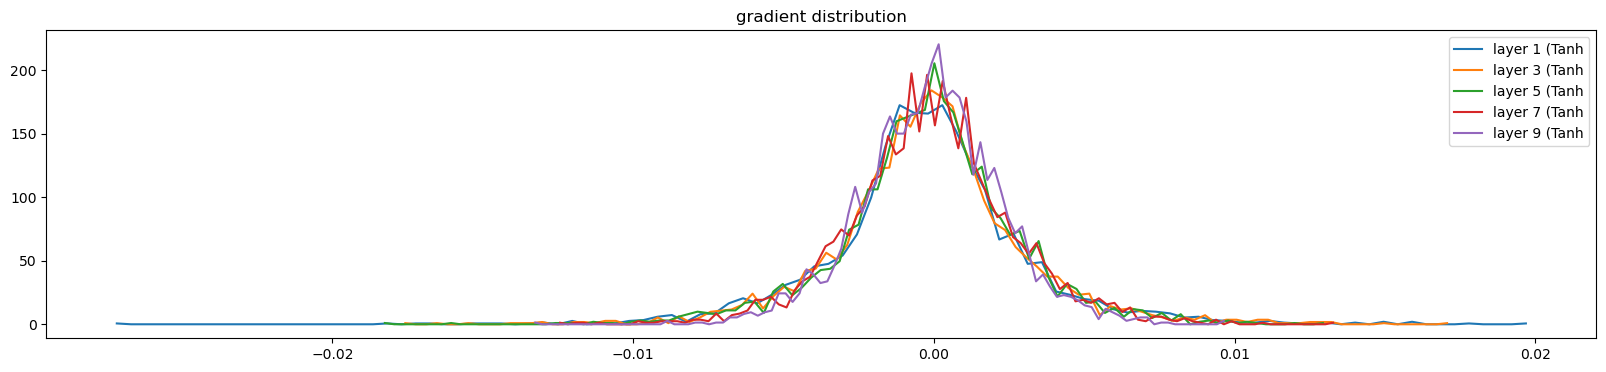

In [67]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
plt.show()